# Evaluation of Relative Quantification Between Classical MN and Feature-Based Molecular Networking

- Author: Louis Felix Nothias, University of California San Diego, louisfelix.nothias@gmail.com
- Env: Python 2.7.15

**Summary**: In this notebook we will compute the R-squared (coefficient of determination) of ordinary least squares Linear regression for Classical Molecular Networking and Feature-Based Molecular Networking (FBMN).

**Steps**: 
- We are starting from an feature quantification table from FBMN (here obtained from MZmine), and Classical MN tables (scan-based and bucket table).
- We are formating the table and merging with metadata (annotations), 
- We filter for annotations that are validated in the NIST SRM sample.
- No normalization is applied here. We used replicates.
- We perform linear regression analysis and some filtering.
- We plot the results for all or annotated with FBMN or classical MN

**Note**: I am new to python, so please forgive if the code lacks of elegance.

## Import and print modules version

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [2]:
# Print modules version from https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook
import types

def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__

excludes = ['builtins', 'types', 'sys']

imported_modules = [module for module in imports() if module not in excludes]

clean_modules = []

for module in imported_modules:

    sep = '.'  # to handle 'matplotlib.pyplot' cases
    rest = module.split(sep, 1)[0]
    clean_modules.append(rest)

changed_imported_modules = list(set(clean_modules))  # drop duplicates

pip_modules = !pip freeze  # you could also use `!conda list` with anaconda

for module in pip_modules:
    name, version = module.split('==')
    if name in changed_imported_modules:
        print(name + '\t' + version)

matplotlib	2.2.2
numpy	1.16.3
pandas	0.23.3
seaborn	0.9.0


## Define the path to FBMN, classical MN, and metadata tables

In [3]:
#Open the feature quantification table
FBMN_filename = 'Input_files/MZmine2_job_v4_2iso/MZmine2_NIST_1950_SRM_QE_LocalMini_MS2_9occurences_2iso_quant.csv'

#MS-Cluster job (https://gnps.ucsd.edu/ProteoSAFe/status.jsp?task=daf3f0d7cec94104b2c9001739964c31)
classicalMN_bucketable_filename = 'Input_files/MSCluster_job_v1/ProteoSAFe-METABOLOMICS-SNETS-V2-daf3f0d7-download_cluster_buckettable/METABOLOMICS-SNETS-V2-daf3f0d7-download_cluster_buckettable-main.tsv'
classicalMN_scans_filename = 'Input_files/MSCluster_job_v1/ProteoSAFe-METABOLOMICS-SNETS-V2-daf3f0d7-download_cytoscape_data/clusterinfosummarygroup_attributes_withIDs_withcomponentID/f7952c5edf9e4afe80dcf7b314b1cfec.txt'

#Define metadata filename
metadata_filename = 'Input_files/Metadata/FeatureBasedMolecularNetworking_NIST_QE.txt'

validated = pd.read_table('Input_files/Metadata/QE_NIST_1950SRM_Annotations_validated.txt',
                          index_col=None, header=0, sep='\t')

### Prepare FBMN table

In [4]:
# Read FBMN feature table
ft = pd.read_table(FBMN_filename, index_col=None, header=None, sep=',')
ft.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,row ID,row m/z,row retention time,L_C18_Polar_16_MS2_DF_125_01.mzML Peak area,L_C18_Polar_16_MS2_DF_125_02.mzML Peak area,L_C18_Polar_16_MS2_DF_25_02.mzML Peak area,L_C18_Polar_16_MS2_DF_125_03.mzML Peak area,L_C18_Polar_16_MS2_DF_25_01.mzML Peak area,L_C18_Polar_16_MS2_DF_5_01.mzML Peak area,L_C18_Polar_16_MS2_DF_25_03.mzML Peak area,L_C18_Polar_16_MS2_DF_625_01.mzML Peak area,L_C18_Polar_16_MS2_DF_625_02.mzML Peak area,L_C18_Polar_16_MS2_DF_5_02.mzML Peak area,L_C18_Polar_16_MS2_DF_5_03.mzML Peak area,L_C18_Polar_16_MS2_DF_625_03.mzML Peak area,L_C18_Polar_16_MS2_DF_1_01.mzML Peak area,L_C18_Polar_16_MS2_DF_1_02.mzML Peak area,L_C18_Polar_16_MS2_DF_1_03.mzML Peak area,NaN
1,1,153.1384063720703,12.76891,1.310016351171587E9,6.383001279041661E8,8.319720332493589E8,9.08095342928712E8,9.9191905653693E8,8.416030054923264E8,1.0897486738823776E9,9.404453222285906E8,4.086167195950484E8,8.576110644667838E8,9.654841528894306E8,5.101146241995175E8,5.779200556979513E8,5.680835038532155E8,5.559559558517644E8,NaN
2,2,124.08675028483073,12.784325555555556,6.324364752176123E8,2.259574712944287E8,3.4653478094445175E8,2.999840009249164E8,5.0943591887278795E8,4.364910378798798E8,4.390045759334787E8,5.110799590768271E8,1.3869672561155772E8,3.741337250646653E8,4.084254100152461E8,1.353602523726266E8,2.9746455510604715E8,3.156973872691429E8,2.811338596159677E8,NaN


In [5]:
# Prepare the FBMN feature quantification table
new_header = ft.iloc[0] #grab the first row for the header
ft = ft[1:] #take the data less the header row
ft.columns = new_header #set the header row as the df header
# Set to float
ft['row m/z'] = ft['row m/z'].astype(float)
ft['row retention time'] = ft['row retention time'].astype(float)

# Set decimal number and apply lambda function
desred_decimals = 4    
ft['row m/z'] = ft['row m/z'].apply(lambda x: round(x,desred_decimals))
desred_decimals = 2    
ft['row retention time'] = ft['row retention time'].apply(lambda x: round(x,desred_decimals))
ft.head(5)

# Copy the table and change back to str to join them in a new column
ft2 = ft
ft2['row ID'] = ft['row ID'].astype(str)
ft2['row m/z'] = ft['row m/z'].astype(str)
ft2['row retention time'] = ft['row retention time'].astype(str)
# Create a unique ID
ft2['ID'] = ft2[['row m/z','row retention time','row ID']].apply(lambda x: '_'.join(x), axis=1)
ft2.head(3)

,row ID,row m/z,row retention time,L_C18_Polar_16_MS2_DF_125_01.mzML Peak area,L_C18_Polar_16_MS2_DF_125_02.mzML Peak area,L_C18_Polar_16_MS2_DF_25_02.mzML Peak area,L_C18_Polar_16_MS2_DF_125_03.mzML Peak area,L_C18_Polar_16_MS2_DF_25_01.mzML Peak area,L_C18_Polar_16_MS2_DF_5_01.mzML Peak area,L_C18_Polar_16_MS2_DF_25_03.mzML Peak area,L_C18_Polar_16_MS2_DF_625_01.mzML Peak area,L_C18_Polar_16_MS2_DF_625_02.mzML Peak area,L_C18_Polar_16_MS2_DF_5_02.mzML Peak area,L_C18_Polar_16_MS2_DF_5_03.mzML Peak area,L_C18_Polar_16_MS2_DF_625_03.mzML Peak area,L_C18_Polar_16_MS2_DF_1_01.mzML Peak area,L_C18_Polar_16_MS2_DF_1_02.mzML Peak area,L_C18_Polar_16_MS2_DF_1_03.mzML Peak area,nan,ID
1,1,153.1384,12.77,1.310016351171587E9,6.383001279041661E8,8.319720332493589E8,9.08095342928712E8,9.9191905653693E8,8.416030054923264E8,1.0897486738823776E9,9.404453222285906E8,4.086167195950484E8,8.576110644667838E8,9.654841528894306E8,5.101146241995175E8,5.779200556979513E8,5.680835038532155E8,5.559559558517644E8,NaN,153.1384_12.77_1
2,2,124.0868,12.78,6.324364752176123E8,2.259574712944287E8,3.4653478094445175E8,2.999840009249164E8,5.0943591887278795E8,4.364910378798798E8,4.390045759334787E8,5.110799590768271E8,1.3869672561155772E8,3.741337250646653E8,4.084254100152461E8,1.353602523726266E8,2.9746455510604715E8,3.156973872691429E8,2.811338596159677E8,NaN,124.0868_12.78_2
3,3,311.0798,5.14,2.2053018946394312E8,2.2252170523560348E8,2.071267881822444E8,2.2899181211310726E8,2.1641347147970533E8,1.9973533794480526E8,2.1983555426273403E8,2.2998004501442787E8,2.2370060215045434E8,2.1488094420564973E8,2.212922978348345E8,2.2011212605587217E8,2.0768248734853014E8,2.366935445575343E8,2.1578526807240492E8,NaN,311.0798_5.14_3


### Prepare classical MN tables

In [6]:
gnps_table_mscluster = pd.read_table(classicalMN_scans_filename, index_col=None, header=0, sep='\t')
classicalMN_bucketable = pd.read_table(classicalMN_bucketable_filename, index_col=None, header=0, sep='\t') #skipows=1 

### Prepare the annotations and get informations

In [7]:
#Import the validated annotations
validated_annotation = validated[validated['Validation'].str.contains('YES',na=False)]
validated_annotation_list=set(validated_annotation['Compound_Name'])

#Import GNPS DB-results for Feature Based Molecular Networking
gnps_table = pd.read_table('Input_files/MZmine2_job_v4_2iso/ProteoSAFe-FEATURE-BASED-MOLECULAR-NETWORKING-b9c75ead-download_cytoscape_data/DB_result/0b01b0bbab80468283de9e876edc9c28.tsv')
gnps_table = gnps_table.set_index(['#Scan#'])
new_names = [(i,'GNPS_'+i) for i in gnps_table.iloc[:, 0:].columns.values]
gnps_table.rename(columns = dict(new_names), inplace=True)

unique_FBMN_annotations = set(gnps_table['GNPS_Compound_Name'])

#Filter annotations for Classical MN
gnps_table_mscluster2 = gnps_table_mscluster.dropna(subset=['LibraryID'])

#Make the sets:
a=set(gnps_table['GNPS_Compound_Name']) #FBMN
b=set(gnps_table_mscluster2['LibraryID']) #Classical MN
#Intersection
x = a.intersection(b)

##### FBMN
#Filter the table for FBMN
gnps_table_ft2 = gnps_table
gnps_table_ft_set = gnps_table_ft2[gnps_table_ft2.GNPS_Compound_Name.isin(x)]

#Keep only the validated annotation 
gnps_table_ft_set = gnps_table_ft_set[gnps_table_ft_set.GNPS_Compound_Name.isin(validated_annotation_list)]
gnps_table_ft_set_validated = gnps_table_ft_set


#### CLASSICAL MN SCANS
#Number of validated annotations in Classical MN
gnps_table_ms_cluster_validated = gnps_table_mscluster2[gnps_table_mscluster2.LibraryID.isin(x)]
gnps_table_ms_cluster_set = gnps_table_ms_cluster_validated[gnps_table_ms_cluster_validated.LibraryID.isin(validated_annotation_list)]

df7 = gnps_table_ms_cluster_validated
gnps_table2 = gnps_table_ms_cluster_validated

# Get the unique values in the filtered table (shared annotations only)
a1=set(gnps_table_ft_set_validated['GNPS_Compound_Name'])
a2=set(gnps_table_ms_cluster_set['LibraryID'])

print('======= Feature based MN ========')
print('Number of annotations in FBMN')
print(validated.shape[0])

print('Number of unique annotations in FBMN')
print(len(unique_FBMN_annotations))

print('Number of unique validated compounds in FBMN')
print(len(validated_annotation_list))

print('======= MS-Cluster based MN ========')

print('Number of annotation in classical MN')
print(len(gnps_table_mscluster2['LibraryID']))
print('Number of validated annotations in classical MN')
print(len(b))

print('Number of validated unique annotations in classical MN')
print(len(set(gnps_table_ms_cluster_set)))

print('======= Shared between FBMN and classical MN ========')

print('Number of validated annotations shared between FBMN and classical MN')
print(gnps_table_ft_set.shape[0])

print('Number of validated unique annotations shared between FBMN and classical MN')
print(len(a1))


======= Feature based MN ========
Number of annotations in FBMN
220
Number of unique annotations in FBMN
161
Number of unique validated compounds in FBMN
51
======= MS-Cluster based MN ========
Number of annotation in classical MN
313
Number of validated annotations in classical MN
223
Number of validated unique annotations in classical MN
57
======= Shared between FBMN and classical MN ========
Number of validated annotations shared between FBMN and classical MN
61
Number of validated unique annotations shared between FBMN and classical MN
40


### Merge feature quantification table and feature metadata

In [8]:
# Merge the metadata and ft2 (FBMN)
# Here the columns has to be from the 
ftX = ft2
ftX.rename(columns={"row ID":'#Scan#'}, inplace=True)
ftX['#Scan#'] = ftX['#Scan#'].astype(int)
#ftX = ftX.set_index('#Scan#')
ftX[[ 'L_C18_Polar_16_MS2_DF_1_01.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_1_02.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_1_03.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_125_01.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_125_02.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_125_03.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_25_01.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_25_02.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_25_03.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_5_01.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_5_02.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_5_03.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_625_01.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_625_02.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_625_03.mzML Peak area','ID']] = ftX[['L_C18_Polar_16_MS2_DF_1_01.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_1_02.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_1_03.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_125_01.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_125_02.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_125_03.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_25_01.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_25_02.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_25_03.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_5_01.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_5_02.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_5_03.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_625_01.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_625_02.mzML Peak area',
       'L_C18_Polar_16_MS2_DF_625_03.mzML Peak area','ID']]

# Merge with all the features
ft2_all = ftX.merge(gnps_table, on=['#Scan#'], how='outer')
ft2_all.head(3)

,#Scan#,row m/z,row retention time,L_C18_Polar_16_MS2_DF_125_01.mzML Peak area,L_C18_Polar_16_MS2_DF_125_02.mzML Peak area,L_C18_Polar_16_MS2_DF_25_02.mzML Peak area,L_C18_Polar_16_MS2_DF_125_03.mzML Peak area,L_C18_Polar_16_MS2_DF_25_01.mzML Peak area,L_C18_Polar_16_MS2_DF_5_01.mzML Peak area,L_C18_Polar_16_MS2_DF_25_03.mzML Peak area,...,GNPS_RT_Query,GNPS_SharedPeaks,GNPS_Smiles,GNPS_SpecCharge,GNPS_SpecMZ,GNPS_SpectrumFile,GNPS_SpectrumID,GNPS_TIC_Query,GNPS_UpdateWorkflowName,GNPS_tags
0,1,153.1384,12.77,1.310016351171587E9,6.383001279041661E8,8.319720332493589E8,9.08095342928712E8,9.9191905653693E8,8.416030054923264E8,1.0897486738823776E9,...,0.0,5.0,C1CCC2=NCCCN2CC1,1.0,153.138,spectra/specs_ms.mgf,CCMSLIB00003265542,76800.0,UPDATE-SINGLE-ANNOTATED-BRONZE,
1,2,124.0868,12.78,6.324364752176123E8,2.259574712944287E8,3.4653478094445175E8,2.999840009249164E8,5.0943591887278795E8,4.364910378798798E8,4.390045759334787E8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,311.0798,5.14,2.2053018946394312E8,2.2252170523560348E8,2.071267881822444E8,2.2899181211310726E8,2.1641347147970533E8,1.9973533794480526E8,2.1983555426273403E8,...,0.0,11.0,COC1=NC(=NC(=C1)NS(=O)(=O)C2=CC=C(C=C2)N)OC,1.0,311.080,spectra/specs_ms.mgf,CCMSLIB00003199179,31210000.0,UPDATE-SINGLE-ANNOTATED-BRONZE,


In [9]:
## Merge with annotated features
ft2_id = ftX.merge(gnps_table, on=['#Scan#'], how='inner')
print(ft2_id.shape)
#Filter feature below 10 ppm
ft2_id = ft2_id.loc[ft2_id['GNPS_MZErrorPPM'] < 5 ]
print(ft2_id.shape)
ft2_id.head(2)

(220, 55)
(213, 55)


,#Scan#,row m/z,row retention time,L_C18_Polar_16_MS2_DF_125_01.mzML Peak area,L_C18_Polar_16_MS2_DF_125_02.mzML Peak area,L_C18_Polar_16_MS2_DF_25_02.mzML Peak area,L_C18_Polar_16_MS2_DF_125_03.mzML Peak area,L_C18_Polar_16_MS2_DF_25_01.mzML Peak area,L_C18_Polar_16_MS2_DF_5_01.mzML Peak area,L_C18_Polar_16_MS2_DF_25_03.mzML Peak area,...,GNPS_RT_Query,GNPS_SharedPeaks,GNPS_Smiles,GNPS_SpecCharge,GNPS_SpecMZ,GNPS_SpectrumFile,GNPS_SpectrumID,GNPS_TIC_Query,GNPS_UpdateWorkflowName,GNPS_tags
0,1,153.1384,12.77,1.310016351171587E9,6.383001279041661E8,8.319720332493589E8,9.08095342928712E8,9.9191905653693E8,8.416030054923264E8,1.0897486738823776E9,...,0,5,C1CCC2=NCCCN2CC1,1,153.138,spectra/specs_ms.mgf,CCMSLIB00003265542,76800.0,UPDATE-SINGLE-ANNOTATED-BRONZE,
1,3,311.0798,5.14,2.2053018946394312E8,2.2252170523560348E8,2.071267881822444E8,2.2899181211310726E8,2.1641347147970533E8,1.9973533794480526E8,2.1983555426273403E8,...,0,11,COC1=NC(=NC(=C1)NS(=O)(=O)C2=CC=C(C=C2)N)OC,1,311.080,spectra/specs_ms.mgf,CCMSLIB00003199179,31210000.0,UPDATE-SINGLE-ANNOTATED-BRONZE,


In [10]:
ft2_id = ftX.merge(gnps_table_ft_set, on=['#Scan#'], how='inner')

In [11]:
#check the size of 
print(ft2.shape)
print(ft2_id.shape)

(1079, 20)
(61, 55)


### Prepare metadata table

In [12]:
#import the metadata table
metadata = pd.read_table(metadata_filename, low_memory=False, index_col=None, header=0, sep='\t',
                         dtype=str)
a = metadata.shape[1]
metadata.head(2)

,filename,path,Concentration,Dilution,Replicate,Metadata_column
0,L_C18_Polar_16_Blk_no_inj_02.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_Blk_no_...,0,NaN,1,C18_Polar_16
1,L_C18_Polar_16_Blk_no_inj_04.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_Blk_no_...,0,NaN,2,C18_Polar_16


In [13]:
ft2.head(2)

,#Scan#,row m/z,row retention time,L_C18_Polar_16_MS2_DF_125_01.mzML Peak area,L_C18_Polar_16_MS2_DF_125_02.mzML Peak area,L_C18_Polar_16_MS2_DF_25_02.mzML Peak area,L_C18_Polar_16_MS2_DF_125_03.mzML Peak area,L_C18_Polar_16_MS2_DF_25_01.mzML Peak area,L_C18_Polar_16_MS2_DF_5_01.mzML Peak area,L_C18_Polar_16_MS2_DF_25_03.mzML Peak area,L_C18_Polar_16_MS2_DF_625_01.mzML Peak area,L_C18_Polar_16_MS2_DF_625_02.mzML Peak area,L_C18_Polar_16_MS2_DF_5_02.mzML Peak area,L_C18_Polar_16_MS2_DF_5_03.mzML Peak area,L_C18_Polar_16_MS2_DF_625_03.mzML Peak area,L_C18_Polar_16_MS2_DF_1_01.mzML Peak area,L_C18_Polar_16_MS2_DF_1_02.mzML Peak area,L_C18_Polar_16_MS2_DF_1_03.mzML Peak area,nan,ID
1,1,153.1384,12.77,1.310016351171587E9,6.383001279041661E8,8.319720332493589E8,9.08095342928712E8,9.9191905653693E8,8.416030054923264E8,1.0897486738823776E9,9.404453222285906E8,4.086167195950484E8,8.576110644667838E8,9.654841528894306E8,5.101146241995175E8,5.779200556979513E8,5.680835038532155E8,5.559559558517644E8,NaN,153.1384_12.77_1
2,2,124.0868,12.78,6.324364752176123E8,2.259574712944287E8,3.4653478094445175E8,2.999840009249164E8,5.0943591887278795E8,4.364910378798798E8,4.390045759334787E8,5.110799590768271E8,1.3869672561155772E8,3.741337250646653E8,4.084254100152461E8,1.353602523726266E8,2.9746455510604715E8,3.156973872691429E8,2.811338596159677E8,NaN,124.0868_12.78_2


### Merge with metadata table for all the features

In [14]:
#Check the other table
ft2_all.head(2)

,#Scan#,row m/z,row retention time,L_C18_Polar_16_MS2_DF_125_01.mzML Peak area,L_C18_Polar_16_MS2_DF_125_02.mzML Peak area,L_C18_Polar_16_MS2_DF_25_02.mzML Peak area,L_C18_Polar_16_MS2_DF_125_03.mzML Peak area,L_C18_Polar_16_MS2_DF_25_01.mzML Peak area,L_C18_Polar_16_MS2_DF_5_01.mzML Peak area,L_C18_Polar_16_MS2_DF_25_03.mzML Peak area,...,GNPS_RT_Query,GNPS_SharedPeaks,GNPS_Smiles,GNPS_SpecCharge,GNPS_SpecMZ,GNPS_SpectrumFile,GNPS_SpectrumID,GNPS_TIC_Query,GNPS_UpdateWorkflowName,GNPS_tags
0,1,153.1384,12.77,1.310016351171587E9,6.383001279041661E8,8.319720332493589E8,9.08095342928712E8,9.9191905653693E8,8.416030054923264E8,1.0897486738823776E9,...,0.0,5.0,C1CCC2=NCCCN2CC1,1.0,153.138,spectra/specs_ms.mgf,CCMSLIB00003265542,76800.0,UPDATE-SINGLE-ANNOTATED-BRONZE,
1,2,124.0868,12.78,6.324364752176123E8,2.259574712944287E8,3.4653478094445175E8,2.999840009249164E8,5.0943591887278795E8,4.364910378798798E8,4.390045759334787E8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Tranpose the table to facilitate cleaning
ft2 = ft2.T
ft3 = ft2.reset_index(level=None, drop=False, inplace=False, col_level=0, col_fill='')

ft3[0] = ft3[0].str.replace(' Peak area', '') ## Leave the empty space before Peak area
ft3.set_index(0)

# Redefine the index with ID row
ft3.columns = ft3.iloc[(ft3.shape[0])-1]
ft3.rename(columns={'ID':'#SampleID'}, inplace=True)
ft3.head(3)

19,#SampleID,153.1384_12.77_1,124.0868_12.78_2,311.0798_5.14_3,274.2734_6.1_4,158.1538_6.17_5,102.0337_12.97_6,111.0201_12.84_7,162.1123_0.3_8,139.9877_12.84_9,...,954.4845_6.23_1070,848.6524_9.63_1071,1342.924_11.97_1072,475.3248_1.62_1073,757.7139_4.29_1074,1066.8012_6.38_1075,716.2285_10.59_1076,518.4923_11.16_1077,827.7084_11.39_1078,790.247_10.89_1079
0,#Scan#,1,2,3,4,5,6,7,8,9,...,1070,1071,1072,1073,1074,1075,1076,1077,1078,1079
1,row m/z,153.1384,124.0868,311.0798,274.2734,158.1538,102.0337,111.0201,162.1123,139.9877,...,954.4845,848.6524,1342.924,475.3248,757.7139,1066.8012,716.2285,518.4923,827.7084,790.247
2,row retention time,12.77,12.78,5.14,6.1,6.17,12.97,12.84,0.3,12.84,...,6.23,9.63,11.97,1.62,4.29,6.38,10.59,11.16,11.39,10.89


In [16]:
# Tranpose the table to facilitate cleaning

ft3.rename(columns={'ID':'#SampleID'}, inplace=True)
ft3_ID = ft3
ft3.shape

(20, 1080)

In [17]:
metadata.head(2)
#ft3.columns = ft3.iloc[680]
metadata.rename(columns={'filename':'#SampleID'}, inplace=True)
metadata.head(10)

,#SampleID,path,Concentration,Dilution,Replicate,Metadata_column
0,L_C18_Polar_16_Blk_no_inj_02.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_Blk_no_...,0,NaN,1,C18_Polar_16
1,L_C18_Polar_16_Blk_no_inj_04.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_Blk_no_...,0,NaN,2,C18_Polar_16
2,L_C18_Polar_16_Blk_no_inj_06.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_Blk_no_...,0,NaN,3,C18_Polar_16
3,L_C18_Polar_16_Blk_no_inj_08.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_Blk_no_...,0,NaN,4,C18_Polar_16
4,L_C18_Polar_16_MS2_DF_1_01.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,1,1,1,C18_Polar_16
5,L_C18_Polar_16_MS2_DF_1_02.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,1,1,2,C18_Polar_16
6,L_C18_Polar_16_MS2_DF_1_03.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,1,1,3,C18_Polar_16
7,L_C18_Polar_16_MS2_DF_125_01.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,0.008,125,1,C18_Polar_16
8,L_C18_Polar_16_MS2_DF_125_02.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,0.008,125,2,C18_Polar_16
9,L_C18_Polar_16_MS2_DF_125_03.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,0.008,125,3,C18_Polar_16


In [18]:
# Merge the metadata and ft2
dfa = pd.merge(metadata,ft3, on=['#SampleID'], how='right') # pd.concat()
dfa = dfa.loc[dfa['Dilution'] > 1]
print(dfa.shape)
dfa.head(5)

(15, 1085)


,#SampleID,path,Concentration,Dilution,Replicate,Metadata_column,153.1384_12.77_1,124.0868_12.78_2,311.0798_5.14_3,274.2734_6.1_4,...,954.4845_6.23_1070,848.6524_9.63_1071,1342.924_11.97_1072,475.3248_1.62_1073,757.7139_4.29_1074,1066.8012_6.38_1075,716.2285_10.59_1076,518.4923_11.16_1077,827.7084_11.39_1078,790.247_10.89_1079
0,L_C18_Polar_16_MS2_DF_1_01.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,1,1,1,C18_Polar_16,5.779200556979513E8,2.9746455510604715E8,2.0768248734853014E8,1.2540036195157573E8,...,390955.7677285116,0,327393.81776368886,1995528.8175781248,1582267.9789062478,176651.53764062334,1274.4411706540297,183877.10947655956,4682.347140258678,5126.216608032109
1,L_C18_Polar_16_MS2_DF_1_02.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,1,1,2,C18_Polar_16,5.680835038532155E8,3.156973872691429E8,2.366935445575343E8,1.7308819311099395E8,...,1171601.5940431622,683469.5444471593,343342.98563132266,903139.0216499947,1655088.21578614,682041.2075800849,2076.383452148915,135655.91200781247,723.0341491701163,2175.6233811036445
2,L_C18_Polar_16_MS2_DF_1_03.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,1,1,3,C18_Polar_16,5.559559558517644E8,2.811338596159677E8,2.1578526807240492E8,1.0843681569894579E8,...,1470095.0544747019,2078311.9890654548,317727.2401331797,2868821.0634174114,1707552.7662343902,1105008.0698649606,495882.6236324489,996874.1991423066,197718.77165253402,170226.23524386753
3,L_C18_Polar_16_MS2_DF_125_01.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,0.008,125,1,C18_Polar_16,1.310016351171587E9,6.324364752176123E8,2.2053018946394312E8,1.911689511524762E8,...,0,7943.2099804686895,6836.100556639862,125771.77328007753,1985.3989003905072,0,19658.391260009757,0,22370.297867186473,3587.3793825692555
4,L_C18_Polar_16_MS2_DF_125_02.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,0.008,125,2,C18_Polar_16,6.383001279041661E8,2.259574712944287E8,2.2252170523560348E8,2.0576841466275817E8,...,2335.1490263671744,0,3099.500246582237,53841.19898715798,1725.6089843750399,0,9135.66886694266,412.46580761717166,0,3537.327649047519


### Merge with metadata table for the annotated features

In [19]:
# Tranpose the table to facilitate cleaning
ft2_id2 = ft2_id.T
ft3id = ft2_id2.reset_index(level=None, drop=False, inplace=False, col_level=0, col_fill='')
ft3id['index'] = ft3id['index'].str.replace(' Peak area', '') ## Leave the empty space before Peak area

ft3id.set_index(0)

# Redefine the index with ID row
ft3id.columns = ft3id.iloc[(ft3id.shape[0])-36]
ft3id.rename(columns={'ID':'#SampleID'}, inplace=True)
print(ft3id.shape)
ft3id.head(5)

(55, 62)


19,#SampleID,162.1123_0.3_8,204.1229_0.37_32,147.0762_0.31_62,524.3704_8.15_70,205.097_1.63_81,188.0704_1.63_85,150.0582_0.39_89,130.0861_0.35_112,338.3409_10.39_115,...,472.303_6.53_705,504.3053_8.1_734,409.1867_1.63_764,325.1704_5.18_770,532.3362_7.83_783,276.1223_3.96_792,504.3415_7.69_805,311.1227_0.94_823,361.2008_5.39_881,306.1326_3.49_988
0,#Scan#,8,32,62,70,81,85,89,112,115,...,705,734,764,770,783,792,805,823,881,988
1,row m/z,162.1123,204.1229,147.0762,524.3704,205.097,188.0704,150.0582,130.0861,338.3409,...,472.303,504.3053,409.1867,325.1704,532.3362,276.1223,504.3415,311.1227,361.2008,306.1326
2,row retention time,0.3,0.37,0.31,8.15,1.63,1.63,0.39,0.35,10.39,...,6.53,8.1,1.63,5.18,7.83,3.96,7.69,0.94,5.39,3.49
3,L_C18_Polar_16_MS2_DF_125_01.mzML,1.2259335834706478E8,3.02781610738971E7,1.5266385103531113E7,1.095689432081518E7,1.1295180720135411E7,9217457.783988856,4797283.969357347,4730524.07288765,2452728.723719494,...,2500.8199511717785,3900.9504501952747,0,0,4250.79669287132,3144.257830078057,2440.156818358939,2231.4117897949254,2809.538719726597,0
4,L_C18_Polar_16_MS2_DF_125_02.mzML,1.2317045252568923E8,2.6063969360836018E7,1.4525851741213316E7,9785275.459913798,1.25585968701577E7,1.0322485929273622E7,4619310.919936459,3994605.6116779754,948589.127285155,...,10956.778203123933,4736.966437500165,0,0,0,1832.6421044923009,5559.41624218785,5936.586073730505,0,0


In [20]:
# Tranpose the table to facilitate cleaning
ft3id.rename(columns={'ID':'#SampleID'}, inplace=True)
ft3id2 = ft3id
ft3id2.shape

(55, 62)

In [21]:
dfa_id = pd.merge(metadata,ft3id2, on=['#SampleID'], how='right') # pd.concat()
dfa_id = dfa_id.loc[dfa_id['Dilution'] > 1]
dfa_id.shape

(15, 67)

In [22]:
dfa_id.head(3)

,#SampleID,path,Concentration,Dilution,Replicate,Metadata_column,162.1123_0.3_8,204.1229_0.37_32,147.0762_0.31_62,524.3704_8.15_70,...,472.303_6.53_705,504.3053_8.1_734,409.1867_1.63_764,325.1704_5.18_770,532.3362_7.83_783,276.1223_3.96_792,504.3415_7.69_805,311.1227_0.94_823,361.2008_5.39_881,306.1326_3.49_988
0,L_C18_Polar_16_MS2_DF_1_01.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,1,1,1,C18_Polar_16,6.128130473249754E8,8.538976547688228E8,3.591976024824724E7,1.294764897400451E9,...,5586569.909537543,3996602.03485154,2.1822432733891957E7,2080348.3010063055,1.3712465306228023E7,1693184.7946547528,6227424.842427127,3383166.094233465,1007280.9183143524,971950.0984423354
1,L_C18_Polar_16_MS2_DF_1_02.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,1,1,2,C18_Polar_16,5.303495207906591E8,6.964682308841292E8,2.370361217080483E7,1.7139627066005902E9,...,4163756.4514018036,4145051.616322349,2.4244304488763735E7,3479569.33397863,1.0658582128797596E7,2044023.197082217,6939286.767871682,3970344.3491932102,903625.0791610889,1077922.2569337825
2,L_C18_Polar_16_MS2_DF_1_03.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,1,1,3,C18_Polar_16,4.22258776785784E8,7.350400004508926E8,4.888518820571424E7,2.159659617515347E9,...,7436003.955494633,5450155.325187883,2.521106444454805E7,2476421.411359737,1.8508100222427867E7,1850055.166312866,7059221.51527459,3986620.6560078496,1525954.65656363,1466230.405271016


In [23]:
##  Apply pd.to_numeric for some columns

dfa[dfa.columns[6:]] = dfa[dfa.columns[6:]].apply(pd.to_numeric)
dfa[['Concentration','Dilution']] = dfa[['Concentration','Dilution']].apply(pd.to_numeric)

In [24]:
print(dfa.shape)
#dfa = dfa[dfa.Dilution != 625]
#dfa = dfa[dfa.Dilution != '125']
#dfa = dfa[dfa.Concentration != 0.2]
print(dfa.shape)

(15, 1085)
(15, 1085)


# Compute the linear regression for the FBMN - all features

In [25]:
# Code found from https://github.com/justmarkham/DAT4/blob/master/notebooks/08_linear_regression.ipynb

# create X and y
feature_cols = dfa.columns[6:]

X = dfa[feature_cols]
y = dfa.Concentration

dfa.head(3)

,#SampleID,path,Concentration,Dilution,Replicate,Metadata_column,153.1384_12.77_1,124.0868_12.78_2,311.0798_5.14_3,274.2734_6.1_4,...,954.4845_6.23_1070,848.6524_9.63_1071,1342.924_11.97_1072,475.3248_1.62_1073,757.7139_4.29_1074,1066.8012_6.38_1075,716.2285_10.59_1076,518.4923_11.16_1077,827.7084_11.39_1078,790.247_10.89_1079
0,L_C18_Polar_16_MS2_DF_1_01.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,1.0,1,1,C18_Polar_16,5.779201e+08,2.974646e+08,2.076825e+08,1.254004e+08,...,3.909558e+05,0.000000e+00,327393.817764,1.995529e+06,1.582268e+06,1.766515e+05,1274.441171,183877.109477,4682.347140,5126.216608
1,L_C18_Polar_16_MS2_DF_1_02.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,1.0,1,2,C18_Polar_16,5.680835e+08,3.156974e+08,2.366935e+08,1.730882e+08,...,1.171602e+06,6.834695e+05,343342.985631,9.031390e+05,1.655088e+06,6.820412e+05,2076.383452,135655.912008,723.034149,2175.623381
2,L_C18_Polar_16_MS2_DF_1_03.mzML,lfnothias/1812_NIST_mix/L_C18_Polar_16_MS2_DF_...,1.0,1,3,C18_Polar_16,5.559560e+08,2.811339e+08,2.157853e+08,1.084368e+08,...,1.470095e+06,2.078312e+06,317727.240133,2.868821e+06,1.707553e+06,1.105008e+06,495882.623632,996874.199142,197718.771653,170226.235244


In [26]:
# Get the coefficient of determination (r-squared)
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
lm = LinearRegression()
lm.fit(X, y)

# print intercept and coefficients
print lm.intercept_
print lm.coef_

-0.001687050910398863
[-1.91311711e-12 -3.28058695e-12  5.74482655e-13 ...  3.54388505e-14
  4.98029525e-14  3.65190497e-15]


In [27]:
#For loop to compute the r-squared

liste2_x = []
liste2 = []
liste3 = []
for x in feature_cols:
    model = LinearRegression()
    X, y = dfa[[x]], dfa.Concentration
    model.fit(X, y)
    liste2_x.append(x)
    liste2.append(model.score(X, y))
    liste3.append(model.coef_)
    
liste2[:5]

[0.20199500232948608,
 0.032157499803486256,
 0.0008494362333754113,
 0.6249455913113358,
 0.48664815438675396]

In [28]:
#Get the mean value for the r-square
print('Mean value for the r-squared in FBMN wo filtering')
print reduce(lambda x, y: x + y, liste2) / len(liste2)

Mean value for the r-squared in FBMN wo filtering
0.6575218800436758


In [29]:
# Prepare the new table for visualization
df_correlation_FMN = pd.DataFrame([x for x in liste2],columns=['r_square_FMN'])
df_coef_FMN = pd.DataFrame([x for x in liste3],columns=['coef_FMN'])
df_feature_FMN = pd.DataFrame([x for x in liste2_x],columns=['Feature_FMN'])
df_feature_FMN['r_square_FMN']= df_correlation_FMN['r_square_FMN']
df_feature_FMN['coef_FMN']= df_coef_FMN['coef_FMN']
df_feature_FMN = df_feature_FMN.set_index('Feature_FMN')
df_feature_FMN = df_feature_FMN.sort_values(by=['r_square_FMN'], ascending=True)
print(df_feature_FMN.shape)

# Clean up the feature that have r < 0 that are assumed to be artefacts (processing/clustering and background ion)
df_feature_FMN = df_feature_FMN[df_feature_FMN['coef_FMN'] > 0]
df_feature_FMN.head(25)
print(df_feature_FMN.shape)

(1079, 2)
(877, 2)


In [30]:
#Get the mean value for the r-squared after the filtering
print reduce(lambda x, y: x + y, df_feature_FMN['r_square_FMN']) / len(df_feature_FMN['r_square_FMN'])
print reduce(lambda x, y: x + y, df_feature_FMN['coef_FMN']) / len(df_feature_FMN['coef_FMN'])

0.785150736894
2.8428205173e-07


/anaconda2/envs/python2_rdkit/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


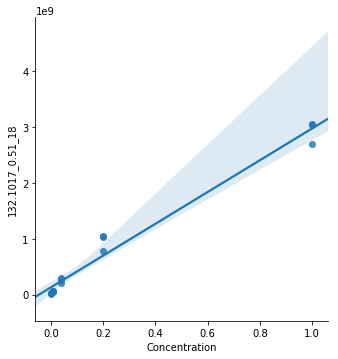

In [31]:
# Plot one feature
sns.pairplot(dfa, x_vars='Concentration', y_vars='132.1017_0.51_18', size=5, aspect=1, kind='reg')

In [32]:
#Change the type of table
dfa_id[dfa_id.columns[6:]] = dfa_id[dfa_id.columns[6:]].apply(pd.to_numeric)
dfa_id[['Concentration','Dilution']] = dfa_id[['Concentration','Dilution']].apply(pd.to_numeric)

## Compute the linear regression for the FBMN - only for annotations


In [33]:
# create X and y
feature_cols = dfa_id.columns[6:]

X = dfa_id[feature_cols]
y = dfa_id.Concentration

In [34]:
# follow the usual sklearn pattern: import, instantiate, fit
lm = LinearRegression()
lm.fit(X, y)

# print intercept and coefficients
print lm.intercept_
print lm.coef_

-0.000619961477092229
[-8.34350486e-11  7.24118201e-11  4.86437449e-10  5.81184217e-12
  4.89019923e-10  3.93848201e-11  2.83309716e-10  2.63648311e-10
  1.83840516e-10 -2.31503703e-10  1.55499812e-10  2.20573307e-10
  1.35873777e-10 -1.15139602e-10  2.24580818e-10 -4.19641637e-11
  9.13149460e-11  3.60101411e-10  1.05502084e-10  5.26417077e-11
  2.57849787e-11 -3.96895364e-11 -2.84050891e-11  2.97627618e-10
 -9.09598906e-12  1.21194233e-11  7.45002170e-11  1.72383243e-15
  2.28356088e-11 -1.50409840e-10  6.69158268e-11  1.65826168e-11
  5.93723252e-11 -1.65105689e-10  1.42719113e-11 -6.75085409e-12
  1.74849581e-11  1.54896734e-11 -7.52374948e-12  3.04691203e-11
  2.12014337e-11  2.31925453e-11 -1.11286950e-11  3.18299290e-12
 -2.19124100e-11  4.15774527e-11 -3.51401626e-10 -1.54233948e-11
  9.23340902e-12  9.14341709e-11  3.15080760e-11  2.41662121e-11
  7.69178714e-12  3.69573978e-11 -9.64425534e-12  7.19918596e-11
 -9.01164687e-13  5.83438087e-12  1.89899874e-12  4.75436247e-12
  2

In [35]:
#For loop to compute the r-square

liste2_x = []
liste2 = []
liste3 = []
for x in feature_cols:
    model = LinearRegression()
    X, y = dfa_id[[x]], dfa_id.Concentration
    model.fit(X, y)
    liste2_x.append(x)
    liste2.append(model.score(X, y))
    liste3.append(model.coef_)
    
liste2[:5]

[0.4359349278854602,
 0.9221409987758732,
 0.45136435320183743,
 0.9384295378560381,
 0.9977390845980999]

In [36]:
# Prepare the new table
df_id_correlation_FMN = pd.DataFrame([x for x in liste2],columns=['r_square_FMN'])
df_id_coef_FMN = pd.DataFrame([x for x in liste3],columns=['coef_FMN'])
df_id_feature_FMN = pd.DataFrame([x for x in liste2_x],columns=['Feature_FMN'])
df_id_feature_FMN['r_square_FMN']= df_id_correlation_FMN['r_square_FMN']
df_id_feature_FMN['coef_FMN']= df_id_coef_FMN['coef_FMN']
df_id_feature_FMN = df_id_feature_FMN.set_index('Feature_FMN')
df_id_feature_FMN = df_id_feature_FMN.sort_values(by=['r_square_FMN'], ascending=True)

print(df_id_feature_FMN.shape)
yo = df_id_feature_FMN.shape[0]
df_id_feature_FMN = df_id_feature_FMN[df_id_feature_FMN['coef_FMN'] > 0]
df_id_feature_FMN.head(25)
print(df_id_feature_FMN.shape)
yo2 = df_id_feature_FMN.shape[0] 

print('This is the number of annotated features with negative coef (probably from the background)')
print(yo-yo2)
# We assume these features are from the background
df_id_feature_FMN.head(20)

(61, 2)
(54, 2)
This is the number of annotated features with negative coef (probably from the background)
7


,r_square_FMN,coef_FMN
Feature_FMN,,
813.6828_9.78_224,0.000299,9.923941e-10
787.6677_9.75_302,0.207222,2.391808e-07
813.6829_10.0_636,0.290374,2.284859e-08
813.6825_12.83_484,0.300760,4.470187e-08
758.5682_12.82_419,0.302627,2.400004e-08
758.5682_10.07_426,0.318825,5.363900e-09
162.1123_0.3_8,0.435935,1.177871e-09
835.6663_12.8_606,0.440534,1.423649e-07
147.0762_0.31_62,0.451364,2.072372e-08


In [37]:
#Get the mean value for the r-square
print reduce(lambda x, y: x + y, df_id_feature_FMN['r_square_FMN']) / len(df_id_feature_FMN['r_square_FMN'])
print reduce(lambda x, y: x + y, df_id_feature_FMN['coef_FMN']) / len(df_id_feature_FMN['coef_FMN'])

0.827966774963
1.13428860485e-07


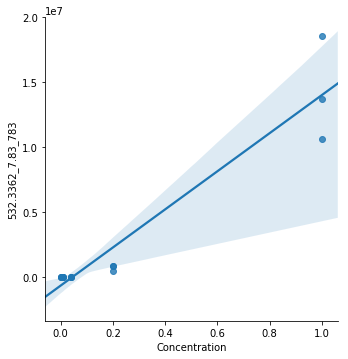

In [38]:
sns.pairplot(dfa_id, x_vars='Concentration', y_vars='532.3362_7.83_783', size=5, aspect=1, kind='reg')

## VISUALISE

## Feature based molecular networking - All features r-square

/anaconda2/envs/python2_rdkit/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


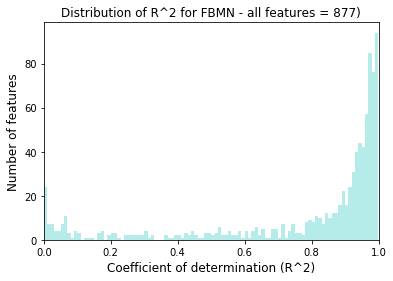

In [39]:
p2=sns.distplot(df_feature_FMN['r_square_FMN'], bins=100, hist = True, kde = False, color = 'mediumturquoise')
p2.set(xlim=(0, 1))

plt.xlabel('Coefficient of determination (R^2)', size =12)
plt.ylabel('Number of features', size =12)
plt.title('Distribution of R^2 for FBMN - all features = '+str(df_feature_FMN.shape[0])+')')
plt.savefig('IMG/FBMN_allfeatures.png', dpi=500)
plt.savefig('IMG/FBMN_allfeatures.svg')

## Feature based molecular networking - Annotations only

/anaconda2/envs/python2_rdkit/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


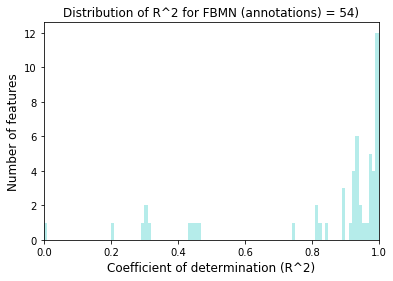

In [40]:
p3=sns.distplot(df_id_feature_FMN['r_square_FMN'], bins=100, hist = True, kde = False, color = 'mediumturquoise')
p3.set(xlim=(0, 1))
plt.xlabel('Coefficient of determination (R^2)', size =12)
plt.ylabel('Number of features', size =12)
plt.title('Distribution of R^2 for FBMN (annotations) = '+str(df_id_feature_FMN.shape[0])+')')
plt.savefig('IMG/FBMN_annotations.png', dpi=500)
plt.savefig('IMG/FBMN_annotations.svg', dpi=500)

# Classical Molecular Networking (scan table)

## Prepare the table

In [41]:
# Set the type of columns
gnps_table_mscluster['precursor mass'] = gnps_table_mscluster['precursor mass'].astype(str)
gnps_table_mscluster['RTMean']= gnps_table_mscluster['RTMean'].astype(str)
gnps_table_mscluster['cluster index']= gnps_table_mscluster['cluster index'].astype(str)
print(gnps_table_mscluster.shape)

(7902, 57)


In [42]:
# Create ID and make a subset
df8 = gnps_table_mscluster
print(df8.shape)

# ========
df8['ID'] = df8['precursor mass'] +'_'+ df8['RTMean'] +'_'+ df8['cluster index']

df8 = df8[['ID','MZErrorPPM','GNPSGROUP:L_C18_Polar_16_MS2_DF_125_01',
       'GNPSGROUP:L_C18_Polar_16_MS2_DF_125_02',
       'GNPSGROUP:L_C18_Polar_16_MS2_DF_125_03',
       'GNPSGROUP:L_C18_Polar_16_MS2_DF_1_01',
       'GNPSGROUP:L_C18_Polar_16_MS2_DF_1_02',
       'GNPSGROUP:L_C18_Polar_16_MS2_DF_1_03',
       'GNPSGROUP:L_C18_Polar_16_MS2_DF_25_01',
       'GNPSGROUP:L_C18_Polar_16_MS2_DF_25_02',
       'GNPSGROUP:L_C18_Polar_16_MS2_DF_25_03',
       'GNPSGROUP:L_C18_Polar_16_MS2_DF_5_01',
       'GNPSGROUP:L_C18_Polar_16_MS2_DF_5_02',
       'GNPSGROUP:L_C18_Polar_16_MS2_DF_5_03',
       'GNPSGROUP:L_C18_Polar_16_MS2_DF_625_01',
       'GNPSGROUP:L_C18_Polar_16_MS2_DF_625_02',
       'GNPSGROUP:L_C18_Polar_16_MS2_DF_625_03']]

df8 = df8.set_index('ID')
print(df8.shape)

df8.head(5)

(7902, 57)
(7902, 16)


,MZErrorPPM,GNPSGROUP:L_C18_Polar_16_MS2_DF_125_01,GNPSGROUP:L_C18_Polar_16_MS2_DF_125_02,GNPSGROUP:L_C18_Polar_16_MS2_DF_125_03,GNPSGROUP:L_C18_Polar_16_MS2_DF_1_01,GNPSGROUP:L_C18_Polar_16_MS2_DF_1_02,GNPSGROUP:L_C18_Polar_16_MS2_DF_1_03,GNPSGROUP:L_C18_Polar_16_MS2_DF_25_01,GNPSGROUP:L_C18_Polar_16_MS2_DF_25_02,GNPSGROUP:L_C18_Polar_16_MS2_DF_25_03,GNPSGROUP:L_C18_Polar_16_MS2_DF_5_01,GNPSGROUP:L_C18_Polar_16_MS2_DF_5_02,GNPSGROUP:L_C18_Polar_16_MS2_DF_5_03,GNPSGROUP:L_C18_Polar_16_MS2_DF_625_01,GNPSGROUP:L_C18_Polar_16_MS2_DF_625_02,GNPSGROUP:L_C18_Polar_16_MS2_DF_625_03
ID,,,,,,,,,,,,,,,,
100.007_15.3957888889_1,NaN,1,1,1,0,0,0,1,1,0,0,0,0,1,1,1
100.07600000000001_49.6009666667_2,2.97321,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0
101.071_638.88998_3,111.80700,5,3,2,5,3,1,5,5,1,5,5,3,4,1,1
102.03_360.11816557699996_4,NaN,22,21,22,21,21,22,22,21,22,21,21,22,21,21,21
102.12799999999999_674.382641026_5,NaN,4,6,6,3,4,5,3,4,5,4,4,5,2,6,6


In [43]:
# ======== FOR VALID ANNOTATIONS
df7['precursor mass'] = df7['precursor mass'].astype(str)
df7['RTMean']= df7['RTMean'].astype(str)
df7['cluster index']= df7['cluster index'].astype(str)

df8_id = df7[df7.LibraryID.isin(validated_annotation_list)]

df8_id['ID'] = df8_id['precursor mass'] +'_'+ df8_id['RTMean'] +'_'+ df8_id['cluster index']

df8_id = df8_id[['ID','MZErrorPPM','GNPSGROUP:L_C18_Polar_16_MS2_DF_125_01',
       'GNPSGROUP:L_C18_Polar_16_MS2_DF_125_02',
       'GNPSGROUP:L_C18_Polar_16_MS2_DF_125_03',
       'GNPSGROUP:L_C18_Polar_16_MS2_DF_1_01',
       'GNPSGROUP:L_C18_Polar_16_MS2_DF_1_02',
       'GNPSGROUP:L_C18_Polar_16_MS2_DF_1_03',
       'GNPSGROUP:L_C18_Polar_16_MS2_DF_25_01',
       'GNPSGROUP:L_C18_Polar_16_MS2_DF_25_02',
       'GNPSGROUP:L_C18_Polar_16_MS2_DF_25_03',
       'GNPSGROUP:L_C18_Polar_16_MS2_DF_5_01',
       'GNPSGROUP:L_C18_Polar_16_MS2_DF_5_02',
       'GNPSGROUP:L_C18_Polar_16_MS2_DF_5_03',
       'GNPSGROUP:L_C18_Polar_16_MS2_DF_625_01',
       'GNPSGROUP:L_C18_Polar_16_MS2_DF_625_02',
       'GNPSGROUP:L_C18_Polar_16_MS2_DF_625_03']]

df8_id = df8_id.set_index('ID')

print(df8_id.shape)
df8_id.head(2)

/anaconda2/envs/python2_rdkit/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda2/envs/python2_rdkit/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/python2_rdkit/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

(61, 16)


/anaconda2/envs/python2_rdkit/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,MZErrorPPM,GNPSGROUP:L_C18_Polar_16_MS2_DF_125_01,GNPSGROUP:L_C18_Polar_16_MS2_DF_125_02,GNPSGROUP:L_C18_Polar_16_MS2_DF_125_03,GNPSGROUP:L_C18_Polar_16_MS2_DF_1_01,GNPSGROUP:L_C18_Polar_16_MS2_DF_1_02,GNPSGROUP:L_C18_Polar_16_MS2_DF_1_03,GNPSGROUP:L_C18_Polar_16_MS2_DF_25_01,GNPSGROUP:L_C18_Polar_16_MS2_DF_25_02,GNPSGROUP:L_C18_Polar_16_MS2_DF_25_03,GNPSGROUP:L_C18_Polar_16_MS2_DF_5_01,GNPSGROUP:L_C18_Polar_16_MS2_DF_5_02,GNPSGROUP:L_C18_Polar_16_MS2_DF_5_03,GNPSGROUP:L_C18_Polar_16_MS2_DF_625_01,GNPSGROUP:L_C18_Polar_16_MS2_DF_625_02,GNPSGROUP:L_C18_Polar_16_MS2_DF_625_03
ID,,,,,,,,,,,,,,,,
100.07600000000001_49.6009666667_2,2.97321,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0
130.086_19.75662_110,2.34595,1,1,0,1,1,1,1,1,0,1,1,1,0,0,0


## For all the features

In [44]:
#  Transpose  the table for easy cleaning
df9 = df8.T
df9.tail(50)

ID,100.007_15.3957888889_1,100.07600000000001_49.6009666667_2,101.071_638.88998_3,102.03_360.11816557699996_4,102.12799999999999_674.382641026_5,103.054_46.3213333333_6,103.955_613.450727273_7,104.10700000000001_17.8528090909_8,104.52799999999999_780.172_9,105.03299999999999_178.438_10,...,1486.12_517.43_7893,1486.56_357.17433333300005_7894,1486.72_356.994_7895,1487.0_453.106_7896,1487.05_357.49800000000005_7897,1488.0_453.00199999999995_7898,1488.11_562.001_7899,1488.14_571.668_7900,1490.11_593.318666667_7901,1492.18_536.577_7902
MZErrorPPM,NaN,2.97321,111.807,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GNPSGROUP:L_C18_Polar_16_MS2_DF_125_01,1.0,0.00000,5.000,22.0,4.0,0.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GNPSGROUP:L_C18_Polar_16_MS2_DF_125_02,1.0,0.00000,3.000,21.0,6.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GNPSGROUP:L_C18_Polar_16_MS2_DF_125_03,1.0,0.00000,2.000,22.0,6.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GNPSGROUP:L_C18_Polar_16_MS2_DF_1_01,0.0,1.00000,5.000,21.0,3.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
GNPSGROUP:L_C18_Polar_16_MS2_DF_1_02,0.0,1.00000,3.000,21.0,4.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
GNPSGROUP:L_C18_Polar_16_MS2_DF_1_03,0.0,1.00000,1.000,22.0,5.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
GNPSGROUP:L_C18_Polar_16_MS2_DF_25_01,1.0,0.00000,5.000,22.0,3.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GNPSGROUP:L_C18_Polar_16_MS2_DF_25_02,1.0,0.00000,5.000,21.0,4.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GNPSGROUP:L_C18_Polar_16_MS2_DF_25_03,0.0,0.00000,1.000,22.0,5.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
df10 = df9[1:]
df10 = df10.reset_index()
df10.head()

ID,index,100.007_15.3957888889_1,100.07600000000001_49.6009666667_2,101.071_638.88998_3,102.03_360.11816557699996_4,102.12799999999999_674.382641026_5,103.054_46.3213333333_6,103.955_613.450727273_7,104.10700000000001_17.8528090909_8,104.52799999999999_780.172_9,...,1486.12_517.43_7893,1486.56_357.17433333300005_7894,1486.72_356.994_7895,1487.0_453.106_7896,1487.05_357.49800000000005_7897,1488.0_453.00199999999995_7898,1488.11_562.001_7899,1488.14_571.668_7900,1490.11_593.318666667_7901,1492.18_536.577_7902
0,GNPSGROUP:L_C18_Polar_16_MS2_DF_125_01,1.0,0.0,5.0,22.0,4.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,GNPSGROUP:L_C18_Polar_16_MS2_DF_125_02,1.0,0.0,3.0,21.0,6.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,GNPSGROUP:L_C18_Polar_16_MS2_DF_125_03,1.0,0.0,2.0,22.0,6.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,GNPSGROUP:L_C18_Polar_16_MS2_DF_1_01,0.0,1.0,5.0,21.0,3.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,GNPSGROUP:L_C18_Polar_16_MS2_DF_1_02,0.0,1.0,3.0,21.0,4.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [46]:
# Crop the group name
df10 = df9[1:]
df10 = df10.reset_index()
df10['Concentration'] = df10['index']

df10['Concentration'] = df10['Concentration'].map(lambda x: str(x)[32:])
df10['Concentration'] = df10['Concentration'].map(lambda x: str(x)[:-3])

#Get the concentration dilution
df10[['Concentration']] = df10[['Concentration']].astype(int)
df10[['Concentration']] = df10[['Concentration']].apply(lambda x: 1/x)

df10 = df10.set_index('index')

df10.head(5)

ID,100.007_15.3957888889_1,100.07600000000001_49.6009666667_2,101.071_638.88998_3,102.03_360.11816557699996_4,102.12799999999999_674.382641026_5,103.054_46.3213333333_6,103.955_613.450727273_7,104.10700000000001_17.8528090909_8,104.52799999999999_780.172_9,105.03299999999999_178.438_10,...,1486.56_357.17433333300005_7894,1486.72_356.994_7895,1487.0_453.106_7896,1487.05_357.49800000000005_7897,1488.0_453.00199999999995_7898,1488.11_562.001_7899,1488.14_571.668_7900,1490.11_593.318666667_7901,1492.18_536.577_7902,Concentration
index,,,,,,,,,,,,,,,,,,,,,
GNPSGROUP:L_C18_Polar_16_MS2_DF_125_01,1.0,0.0,5.0,22.0,4.0,0.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008
GNPSGROUP:L_C18_Polar_16_MS2_DF_125_02,1.0,0.0,3.0,21.0,6.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008
GNPSGROUP:L_C18_Polar_16_MS2_DF_125_03,1.0,0.0,2.0,22.0,6.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008
GNPSGROUP:L_C18_Polar_16_MS2_DF_1_01,0.0,1.0,5.0,21.0,3.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000
GNPSGROUP:L_C18_Polar_16_MS2_DF_1_02,0.0,1.0,3.0,21.0,4.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.000


In [47]:
#Change the type of table
df10[df10.columns] = df10[df10.columns].apply(pd.to_numeric)

## Linear regression analysis for Classical MN

In [48]:
# Prepare the linear regression

# create X and y
feature_cols = df10.columns[:-1]

X = df10[feature_cols]
y = df10.Concentration
y.head(5)

index
GNPSGROUP:L_C18_Polar_16_MS2_DF_125_01    0.008
GNPSGROUP:L_C18_Polar_16_MS2_DF_125_02    0.008
GNPSGROUP:L_C18_Polar_16_MS2_DF_125_03    0.008
GNPSGROUP:L_C18_Polar_16_MS2_DF_1_01      1.000
GNPSGROUP:L_C18_Polar_16_MS2_DF_1_02      1.000
Name: Concentration, dtype: float64

In [49]:
#Function to compute the r-square

liste2_x = []
liste2 = []
liste3 = []
for x in feature_cols:
    model = LinearRegression()
    X, y = df10[[x]], df10.Concentration
    model.fit(X, y)
    liste2_x.append(x)
    liste2.append(model.score(X, y))
    liste3.append(model.coef_)
    
liste2[:5]
len(liste2)

7902

In [50]:
# Prepare the new table with results
df_correlation_MN = pd.DataFrame([x for x in liste2],columns=['r_square_MN'])
df_coef_MN = pd.DataFrame([x for x in liste3],columns=['coef_MN'])
df_feature_MN = pd.DataFrame([x for x in liste2_x],columns=['Feature_MN'])
df_feature_MN['r_square_MN']= df_correlation_MN['r_square_MN']
df_feature_MN['coef_MN']= df_coef_MN['coef_MN']
df_feature_MN = df_feature_MN.set_index('Feature_MN')
df_feature_MN = df_feature_MN.sort_values(by=['r_square_MN'], ascending=False)

print(df_feature_MN.shape)
yo = df_feature_MN.shape[0]
df_feature_MN = df_feature_MN[df_feature_MN['coef_MN'] > 0]
df_feature_MN.head(25)
print(df_feature_MN.shape)
yo2 = df_feature_MN.shape[0] 
print('This is the number of features with negative coef that are assumed to be from the background')
print(yo-yo2)
# The number is huge but expected with background ions in classical MN
df_feature_MN.head(10)

(7902, 2)
(3367, 2)
This is the number of features with negative coef that are assumed to be from the background
4535


,r_square_MN,coef_MN
Feature_MN,,
287.13_330.31233333299997_2554,0.964227,0.9376
610.504_590.952_6154,0.964227,0.9376
190.18_225.828_747,0.964227,0.9376
347.087_270.226_3801,0.964227,0.9376
272.232_96.5127333333_2239,0.964227,0.9376
529.513_232.60633333299998_5555,0.964227,0.9376
530.321_448.103_5560,0.964227,0.9376
530.44_553.544666667_5564,0.964227,0.9376
249.08700000000002_127.58566666700001_1747,0.964227,0.9376


In [51]:
#Get the mean value for the r-square
print reduce(lambda x, y: x + y, df_feature_MN['r_square_MN']) / len(df_feature_MN['r_square_MN'])
print reduce(lambda x, y: x + y, df_feature_MN['coef_MN']) / len(df_feature_MN['coef_MN'])

0.400990487873
0.715087375002


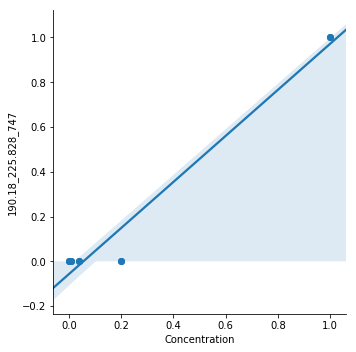

In [52]:
# This is a case where the feature is detected only in the most concentrated sample
sns.pairplot(df10, x_vars='Concentration', y_vars='190.18_225.828_747', size=5, aspect=1, kind='reg')

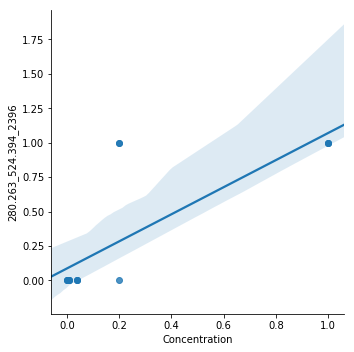

In [53]:
# This is a case where the feature is detected at high concentration and only once a 0.2 
sns.pairplot(df10, x_vars='Concentration', y_vars='280.263_524.394_2396', size=5, aspect=1, kind='reg')

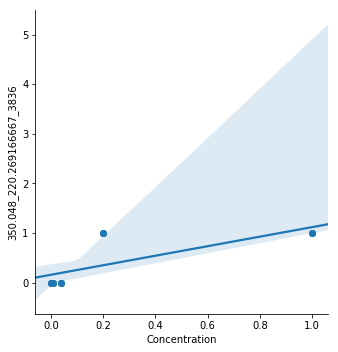

In [54]:
# This is a case where the feature is detected at a concentration 1 and 0.2
sns.pairplot(df10, x_vars='Concentration', y_vars='350.048_220.269166667_3836', size=5, aspect=1, kind='reg')

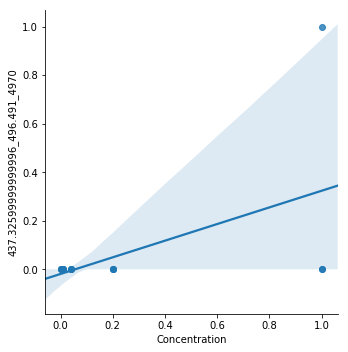

In [55]:
# This is a case where the feature is detected partially in the most intense sample
sns.pairplot(df10, x_vars='Concentration', y_vars='437.32599999999996_496.491_4970', size=5, aspect=1, kind='reg')

In [56]:
#Get the mean value for the r-square
print reduce(lambda x, y: x + y, df_feature_MN['r_square_MN']) / len(df_feature_MN['r_square_MN'])
print reduce(lambda x, y: x + y, df_feature_MN['coef_MN']) / len(df_feature_MN['coef_MN'])

0.400990487873
0.715087375002


/anaconda2/envs/python2_rdkit/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


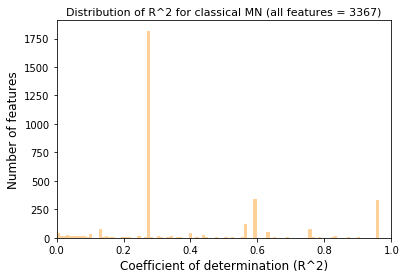

In [57]:
p4=sns.distplot(df_feature_MN['r_square_MN'], bins=100, hist = True, kde = False, color = 'darkorange')
#p1=sns.distplot(df_id_feature_FMN['r_square_FMN'], bins=70, hist = True, kde = False, color = 'mediumturquoise')
p4.set(xlim=(0, 1))

plt.xlabel('Coefficient of determination (R^2)', size =12)
plt.ylabel('Number of features', size =12)
plt.title('Distribution of R^2 for classical MN (all features = '+str(df_feature_MN.shape[0])+')', size = 11)
plt.savefig('IMG/ClassicalMN_allfeatures.png', dpi=500)
plt.savefig('IMG/ClassicalMN_allfeatures.svg', dpi=500)

## For annotated features only

In [58]:
df8_id.columns

Index([u'MZErrorPPM', u'GNPSGROUP:L_C18_Polar_16_MS2_DF_125_01',
       u'GNPSGROUP:L_C18_Polar_16_MS2_DF_125_02',
       u'GNPSGROUP:L_C18_Polar_16_MS2_DF_125_03',
       u'GNPSGROUP:L_C18_Polar_16_MS2_DF_1_01',
       u'GNPSGROUP:L_C18_Polar_16_MS2_DF_1_02',
       u'GNPSGROUP:L_C18_Polar_16_MS2_DF_1_03',
       u'GNPSGROUP:L_C18_Polar_16_MS2_DF_25_01',
       u'GNPSGROUP:L_C18_Polar_16_MS2_DF_25_02',
       u'GNPSGROUP:L_C18_Polar_16_MS2_DF_25_03',
       u'GNPSGROUP:L_C18_Polar_16_MS2_DF_5_01',
       u'GNPSGROUP:L_C18_Polar_16_MS2_DF_5_02',
       u'GNPSGROUP:L_C18_Polar_16_MS2_DF_5_03',
       u'GNPSGROUP:L_C18_Polar_16_MS2_DF_625_01',
       u'GNPSGROUP:L_C18_Polar_16_MS2_DF_625_02',
       u'GNPSGROUP:L_C18_Polar_16_MS2_DF_625_03'],
      dtype='object')

In [59]:
#Filter out for the annotated ones (SET)
df8_id.shape

(61, 16)

In [60]:
# Transpose the table
df9_id = df8_id.T
df9_id.head(10)

ID,100.07600000000001_49.6009666667_2,130.086_19.75662_110,147.076_19.1051636364_260,150.058_24.0401916667_279,162.112_18.4484933333_421,165.054_28.2871444444_438,182.081_27.7098416667_672,188.07_103.79807142899999_706,192.065_45.8808_762,195.08700000000002_207.36455555599997_775,...,753.5889999999999_558.5754_6715,758.569_520.728476744_6733,758.568_232.71099999999998_6734,758.564_301.394_6735,780.551_577.379085714_6803,787.668_534.7295_6829,813.683_548.24572549_6946,813.678_322.564_6947,813.685_531.888_6948,835.666_610.983923077_7052
MZErrorPPM,2.97321,2.34595,2.69743,2.03371,3.10611,3.60543,1.17323,3.1642,2.62171,3.59789,...,1.21489,0.563226,1.8506,0.563226,0.46917,1.00735,1.72525,2.92542,0.750108,0.365189
GNPSGROUP:L_C18_Polar_16_MS2_DF_125_01,0.00000,1.00000,1.00000,1.00000,1.00000,0.00000,1.00000,1.0000,0.00000,0.00000,...,0.00000,0.000000,0.0000,0.000000,0.00000,2.00000,6.00000,0.00000,0.000000,1.000000
GNPSGROUP:L_C18_Polar_16_MS2_DF_125_02,0.00000,1.00000,0.00000,1.00000,1.00000,0.00000,1.00000,1.0000,0.00000,0.00000,...,0.00000,0.000000,0.0000,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000
GNPSGROUP:L_C18_Polar_16_MS2_DF_125_03,0.00000,0.00000,1.00000,1.00000,1.00000,0.00000,1.00000,1.0000,0.00000,0.00000,...,0.00000,0.000000,0.0000,0.000000,0.00000,0.00000,7.00000,0.00000,0.000000,0.000000
GNPSGROUP:L_C18_Polar_16_MS2_DF_1_01,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,3.0000,1.00000,1.00000,...,0.00000,6.000000,0.0000,0.000000,4.00000,0.00000,0.00000,0.00000,0.000000,0.000000
GNPSGROUP:L_C18_Polar_16_MS2_DF_1_02,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,3.0000,0.00000,1.00000,...,0.00000,8.000000,0.0000,0.000000,1.00000,0.00000,3.00000,0.00000,0.000000,2.000000
GNPSGROUP:L_C18_Polar_16_MS2_DF_1_03,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,3.0000,0.00000,1.00000,...,0.00000,9.000000,0.0000,0.000000,1.00000,1.00000,4.00000,0.00000,0.000000,3.000000
GNPSGROUP:L_C18_Polar_16_MS2_DF_25_01,0.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.0000,0.00000,1.00000,...,0.00000,0.000000,0.0000,0.000000,0.00000,1.00000,3.00000,0.00000,1.000000,0.000000
GNPSGROUP:L_C18_Polar_16_MS2_DF_25_02,0.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.0000,0.00000,1.00000,...,0.00000,1.000000,0.0000,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000
GNPSGROUP:L_C18_Polar_16_MS2_DF_25_03,0.00000,0.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.0000,0.00000,1.00000,...,0.00000,1.000000,0.0000,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000


In [61]:
# Crop the group name
df10_id = df9_id[1:]
df10_id = df10_id.reset_index()
df10_id['Concentration'] = df10_id['index']

df10_id['Concentration'] = df10_id['Concentration'].map(lambda x: str(x)[32:])
df10_id['Concentration'] = df10_id['Concentration'].map(lambda x: str(x)[:-3])
df10_id[['Concentration']] = df10_id[['Concentration']].apply(pd.to_numeric)

#Get the concentration dilution
df10_id[['Concentration']] = df10_id[['Concentration']].apply(lambda x: 1/x)

df10_id = df10_id.set_index('index')

df10_id.head(2)

ID,100.07600000000001_49.6009666667_2,130.086_19.75662_110,147.076_19.1051636364_260,150.058_24.0401916667_279,162.112_18.4484933333_421,165.054_28.2871444444_438,182.081_27.7098416667_672,188.07_103.79807142899999_706,192.065_45.8808_762,195.08700000000002_207.36455555599997_775,...,758.569_520.728476744_6733,758.568_232.71099999999998_6734,758.564_301.394_6735,780.551_577.379085714_6803,787.668_534.7295_6829,813.683_548.24572549_6946,813.678_322.564_6947,813.685_531.888_6948,835.666_610.983923077_7052,Concentration
index,,,,,,,,,,,,,,,,,,,,,
GNPSGROUP:L_C18_Polar_16_MS2_DF_125_01,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,6.0,0.0,0.0,1.0,0.008
GNPSGROUP:L_C18_Polar_16_MS2_DF_125_02,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008


## Linear regression analysis

In [62]:
# create X and y
feature_cols_MN = df10_id.columns[:-1]

X = df10_id[feature_cols_MN]
y = df10_id.Concentration
y.head(5)

index
GNPSGROUP:L_C18_Polar_16_MS2_DF_125_01    0.008
GNPSGROUP:L_C18_Polar_16_MS2_DF_125_02    0.008
GNPSGROUP:L_C18_Polar_16_MS2_DF_125_03    0.008
GNPSGROUP:L_C18_Polar_16_MS2_DF_1_01      1.000
GNPSGROUP:L_C18_Polar_16_MS2_DF_1_02      1.000
Name: Concentration, dtype: float64

In [63]:
#Function to compute the r-squared 

liste2_x = []
liste2 = []
liste3 = []
for x in feature_cols_MN:
    model = LinearRegression()
    X, y = df10_id[[x]], df10_id.Concentration
    model.fit(X, y)
    liste2_x.append(x)
    liste2.append(model.score(X, y))
    liste3.append(model.coef_)
    
liste2[:5]

[0.9642271491789653,
 0.19638003459352604,
 0.15174004006640984,
 0.10567872947413348,
 0.0]

In [64]:
# Prepare the new table
df_correlation_MN = pd.DataFrame([x for x in liste2],columns=['r_square_MN'])
df_coef_MN = pd.DataFrame([x for x in liste3],columns=['coef_MN'])
df_feature_MN = pd.DataFrame([x for x in liste2_x],columns=['Feature_MN'])
df_feature_MN['r_square_MN']= df_correlation_MN['r_square_MN']
df_feature_MN['coef_MN']= df_coef_MN['coef_MN']
df_feature_MN = df_feature_MN.set_index('Feature_MN')
df_feature_MN = df_feature_MN.sort_values(by=['r_square_MN'], ascending=False)

print(df_feature_MN.shape)
yo = df_feature_MN.shape[0]
df_feature_MN = df_feature_MN[df_feature_MN['coef_MN'] > 0]
df_feature_MN.head(25)
print(df_feature_MN.shape)
yo2 = df_feature_MN.shape[0] 
print('This is the number of features with negative coef that assumed to be from background')
print(yo-yo2)
df_feature_MN.head(15)

(61, 2)
(49, 2)
This is the number of features with negative coef that assumed to be from background
12


,r_square_MN,coef_MN
Feature_MN,,
100.07600000000001_49.6009666667_2,0.964227,0.937600
188.07_103.79807142899999_706,0.964227,0.468800
306.133_208.872666667_3071,0.964227,0.937600
282.278_552.365_2421,0.964227,0.937600
448.305_378.075333333_5040,0.964227,0.937600
361.20099999999996_324.005333333_4065,0.964227,0.937600
325.17_312.16700000000003_3488,0.964227,0.937600
524.37_498.19375_5533,0.822200,0.285964
546.3530000000001_489.85142424199995_5642,0.802047,0.271928


In [65]:
#Get the mean value for the r-square
print reduce(lambda x, y: x + y, df_feature_MN['r_square_MN']) / len(df_feature_MN['r_square_MN'])
print reduce(lambda x, y: x + y, df_feature_MN['coef_MN']) / len(df_feature_MN['coef_MN'])

0.434153307586
0.468858107295


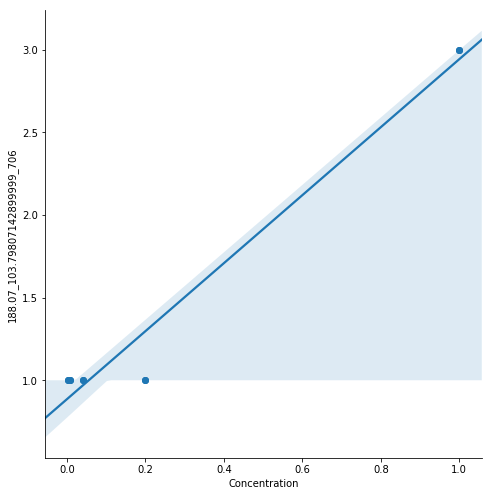

In [66]:
sns.pairplot(df10_id, x_vars='Concentration', y_vars='188.07_103.79807142899999_706', size=7, aspect=1, kind='reg')

/anaconda2/envs/python2_rdkit/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


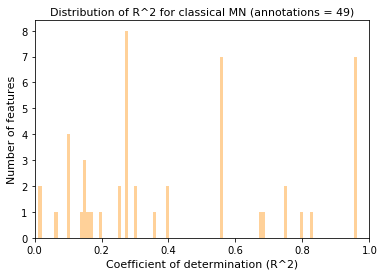

In [67]:
p4=sns.distplot(df_feature_MN['r_square_MN'], bins=100, hist = True, kde = False, color = 'darkorange')
#p1=sns.distplot(df_id_feature_FMN['r_square_FMN'], bins=70, hist = True, kde = False, color = 'b')
                      
p4.set(xlim=(0, 1))
#p1.set(ylim=(0, 4000))

plt.xlabel('Coefficient of determination (R^2)', size =11)
plt.ylabel('Number of features', size =11)
plt.title('Distribution of R^2 for classical MN (annotations = '+str(df_feature_MN.shape[0])+')', size = 11)
plt.savefig('IMG/ClassicalMN_annotations.png', dpi=500)
plt.savefig('IMG/ClassicalMN_annotations.svg')

## Linear regression analysis for classical MN (buckettable)

### Prepare the table

In [68]:
classicalMN_bucketable2 = classicalMN_bucketable.rename(columns={"#OTU ID":'#Scan#'}, inplace=False)
classicalMN_bucketable2 = classicalMN_bucketable2.set_index('#Scan#')
classicalMN_bucketable2.head(3)
print(classicalMN_bucketable2.shape)

(7902, 19)


In [69]:
# Set the type
gnps_table2['precursor mass'] = gnps_table2['precursor mass'].astype(str)
gnps_table2['RTMean']= gnps_table2['RTMean'].astype(str)
gnps_table2.rename(columns={"cluster index":'#Scan#'}, inplace=True)
gnps_table2['#Scan#'] = gnps_table2['#Scan#'].astype(int)
gnps_table2.shape

/anaconda2/envs/python2_rdkit/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda2/envs/python2_rdkit/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/python2_rdkit/lib/python2.7/site-packages/pandas/core/frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

(191, 57)

In [70]:
dfa = pd.merge(gnps_table2,classicalMN_bucketable2, on=['#Scan#'], how='right') # pd.concat()
dfa.head(3)

,ATTRIBUTE_ALL_SAMPLES,ATTRIBUTE_Dilution,ATTRIBUTE_FILENAME,AllGroups,DefaultGroups,EvenOdd,G1,G2,G3,G4,...,L_C18_Polar_16_MS2_DF_25_01,L_C18_Polar_16_MS2_DF_1_02,L_C18_Polar_16_MS2_DF_5_01,L_C18_Polar_16_MS2_DF_1_03,L_C18_Polar_16_Blk_no_inj_06,L_C18_Polar_16_Blk_no_inj_02,L_C18_Polar_16_MS2_DF_125_01,L_C18_Polar_16_MS2_DF_5_03,L_C18_Polar_16_MS2_DF_625_02,L_C18_Polar_16_Blk_no_inj_08
0,SAMPLES,1,"L_C18_Polar_16_MS2_DF_1_02,L_C18_Polar_16_MS2_...","SAMPLES,1,L_C18_Polar_16_MS2_DF_1_01,L_C18_Pol...",G1,1.0,3.0,0.0,0.0,0.0,...,0.0,3561100.0,0.0,2439760.0,0.0,0.0,0.0,0.0,0.0,0.0
1,SAMPLES,"5,25,1,125","L_C18_Polar_16_MS2_DF_1_02,L_C18_Polar_16_MS2_...","L_C18_Polar_16_MS2_DF_125_02,L_C18_Polar_16_MS...",G1,1.0,10.0,0.0,0.0,0.0,...,3165370.0,11598700.0,7616470.0,14275300.0,0.0,0.0,1360080.0,2336730.0,0.0,0.0
2,SAMPLES,"5,625,25,1,125","L_C18_Polar_16_MS2_DF_25_03,L_C18_Polar_16_MS2...","L_C18_Polar_16_MS2_DF_125_03,L_C18_Polar_16_MS...",G1,1.0,15.0,0.0,0.0,0.0,...,3843640.0,21607400.0,6967950.0,24649000.0,0.0,0.0,4646380.0,6768530.0,1485120.0,0.0


In [71]:
# Create ID column and make a subset
dfa
dfa = dfa[['L_C18_Polar_16_MS2_DF_125_01',
       'L_C18_Polar_16_MS2_DF_125_02',
       'L_C18_Polar_16_MS2_DF_125_03',
       'L_C18_Polar_16_MS2_DF_1_01',
       'L_C18_Polar_16_MS2_DF_1_02',
       'L_C18_Polar_16_MS2_DF_1_03',
       'L_C18_Polar_16_MS2_DF_25_01',
       'L_C18_Polar_16_MS2_DF_25_02',
       'L_C18_Polar_16_MS2_DF_25_03',
       'L_C18_Polar_16_MS2_DF_5_01',
       'L_C18_Polar_16_MS2_DF_5_02',
       'L_C18_Polar_16_MS2_DF_5_03',
       'L_C18_Polar_16_MS2_DF_625_01',
       'L_C18_Polar_16_MS2_DF_625_02',
       'L_C18_Polar_16_MS2_DF_625_03','MZErrorPPM','LibraryID']]

dfa.head(2)

,L_C18_Polar_16_MS2_DF_125_01,L_C18_Polar_16_MS2_DF_125_02,L_C18_Polar_16_MS2_DF_125_03,L_C18_Polar_16_MS2_DF_1_01,L_C18_Polar_16_MS2_DF_1_02,L_C18_Polar_16_MS2_DF_1_03,L_C18_Polar_16_MS2_DF_25_01,L_C18_Polar_16_MS2_DF_25_02,L_C18_Polar_16_MS2_DF_25_03,L_C18_Polar_16_MS2_DF_5_01,L_C18_Polar_16_MS2_DF_5_02,L_C18_Polar_16_MS2_DF_5_03,L_C18_Polar_16_MS2_DF_625_01,L_C18_Polar_16_MS2_DF_625_02,L_C18_Polar_16_MS2_DF_625_03,MZErrorPPM,LibraryID
0,0.0,0.0,0.0,4541460.0,3561100.0,2439760.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.97321,5-Aminovaleric acid
1,1360080.0,1270470.0,0.0,1234250.0,11598700.0,14275300.0,3165370.0,3137150.0,0.0,7616470.0,1427510.0,2336730.0,0.0,0.0,0.0,2.34595,L-Lysine


In [72]:
# Transpose the table
dfa2 = dfa
dfa2 = dfa2.drop(['LibraryID'], axis=1)
dfa2 = dfa2.T
dfa2 = dfa2[:-1]
dfa2.tail(2)

,0,1,2,3,4,5,6,7,8,9,...,7892,7893,7894,7895,7896,7897,7898,7899,7900,7901
L_C18_Polar_16_MS2_DF_625_02,0.0,0.0,1485120.0,188996.0,0.0,0.0,0.0,0.0,0.0,0.0,...,704645.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,211278.0,0.0
L_C18_Polar_16_MS2_DF_625_03,0.0,0.0,1460490.0,258305.0,0.0,0.0,0.0,0.0,33830700.0,0.0,...,503852.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,215970.0,0.0


In [73]:
# Continue processing
dfa2 = dfa2.reset_index(drop=False)
dfa2['Concentration'] = dfa2['index']

dfa2['Concentration'] = dfa2['Concentration'].map(lambda x: str(x)[22:])
dfa2['Concentration'] = dfa2['Concentration'].map(lambda x: str(x)[:-3])

#Get the concentration dilution
dfa2[['Concentration']] = dfa2[['Concentration']].astype(int)
dfa2[['Concentration']] = dfa2[['Concentration']].apply(lambda x: 1/x)

dfa2.head(3)

,index,0,1,2,3,4,5,6,7,8,...,7893,7894,7895,7896,7897,7898,7899,7900,7901,Concentration
0,L_C18_Polar_16_MS2_DF_125_01,0.0,1360080.0,4646380.0,0.0,3885420.0,2496090.0,1730780.0,0.0,25723750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,126639.0,0.0,0.008
1,L_C18_Polar_16_MS2_DF_125_02,0.0,1270470.0,4096550.0,633231.0,6461150.0,0.0,1589060.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,140360.0,0.0,0.008
2,L_C18_Polar_16_MS2_DF_125_03,0.0,0.0,3281990.0,1200900.0,7077230.0,3511240.0,1690960.0,0.0,20569700.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,140406.0,0.0,0.008


### Linear regression for classical MN buckettable (all features)

In [74]:
# Prepare the linear regression

# create X and y
feature_cols_MN = dfa2.columns[1:-1]

X = dfa2[feature_cols_MN]
y = dfa2.Concentration
y.head(5)

0    0.008
1    0.008
2    0.008
3    1.000
4    1.000
Name: Concentration, dtype: float64

In [75]:
#For loops to compute the r-square

liste2_x = []
liste2 = []
liste3 = []
for x in feature_cols_MN:
    model = LinearRegression()
    X, y = dfa2[[x]], dfa2.Concentration
    model.fit(X, y)
    liste2_x.append(x)
    liste2.append(model.score(X, y))
    liste3.append(model.coef_)
    
liste2[:5]

[0.8972631964632976,
 0.5198107084420003,
 0.9661130649664008,
 0.10557425468921111,
 0.8204181106913536]

In [76]:
# Prepare the new table
df_correlation_MN = pd.DataFrame([x for x in liste2],columns=['r_square_MN'])
df_coef_MN = pd.DataFrame([x for x in liste3],columns=['coef_MN'])
df_feature_MN = pd.DataFrame([x for x in liste2_x],columns=['Feature_MN'])
df_feature_MN['r_square_MN']= df_correlation_MN['r_square_MN']
df_feature_MN['coef_MN']= df_coef_MN['coef_MN']
df_feature_MN = df_feature_MN.set_index('Feature_MN')
df_feature_MN = df_feature_MN.sort_values(by=['r_square_MN'], ascending=False)

print(df_feature_MN.shape)
yo = df_feature_MN.shape[0]
df_feature_MN = df_feature_MN[df_feature_MN['coef_MN'] > 0]
df_feature_MN.head(25)
print(df_feature_MN.shape)
yo2 = df_feature_MN.shape[0] 
print('This is the number of features with negative coef that are assumed to be from the background')
print(yo-yo2)
df_feature_MN.head(15)

(7902, 2)
(3414, 2)
This is the number of features with negative coef that are assumed to be from the background
4488


,r_square_MN,coef_MN
Feature_MN,,
3484,0.997361,5.934087e-08
6383,0.994219,2.540618e-07
117,0.993574,4.982304e-07
18,0.992161,4.039346e-07
4974,0.992052,4.273675e-07
1709,0.991966,2.874411e-07
1280,0.991567,1.622432e-06
71,0.991433,9.814346e-07
764,0.991342,4.059183e-07


In [77]:
#Get the mean value for the r-square
print reduce(lambda x, y: x + y, df_feature_MN['r_square_MN']) / len(df_feature_MN['r_square_MN'])
print reduce(lambda x, y: x + y, df_feature_MN['coef_MN']) / len(df_feature_MN['coef_MN'])

0.433353511867
0.00282912652918


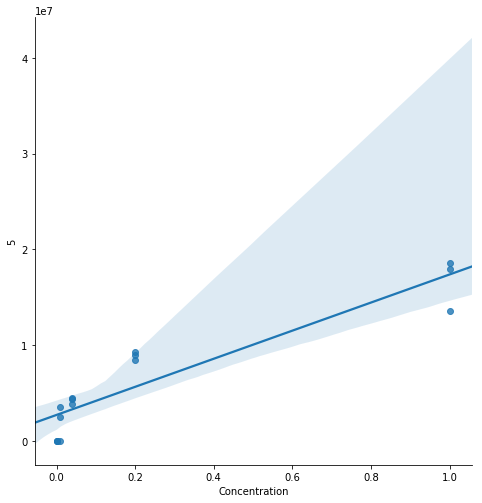

In [78]:
dfa2[['Concentration']] = dfa2[['Concentration']].apply(pd.to_numeric)
sns.pairplot(dfa2, x_vars='Concentration', y_vars=5, size=7, aspect=1, kind='reg')

## VISUALIZE THE RESULTS

/anaconda2/envs/python2_rdkit/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


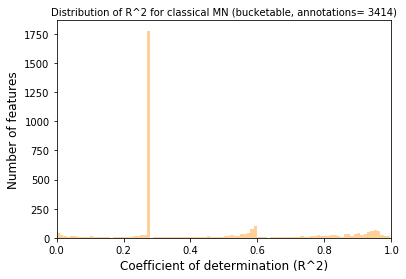

In [79]:
p1=sns.distplot(df_feature_MN['r_square_MN'], bins=100, hist = True, kde = False, color = 'darkorange')
                      
p1.set(xlim=(0, 1))

plt.xlabel('Coefficient of determination (R^2)', size =12)
plt.ylabel('Number of features', size =12)
plt.title('Distribution of R^2 for classical MN (bucketable, annotations= '+str(df_feature_MN.shape[0])+')', size = 10)
plt.savefig('IMG/ClassicalMN_allfeatures_buckettable.png', dpi=500)
plt.savefig('IMG/ClassicalMN_allfeatures_buckettable.svg')

In [80]:
# Create ID column and make a subset
dfa_id = dfa[['L_C18_Polar_16_MS2_DF_125_01',
       'L_C18_Polar_16_MS2_DF_125_02',
       'L_C18_Polar_16_MS2_DF_125_03',
       'L_C18_Polar_16_MS2_DF_1_01',
       'L_C18_Polar_16_MS2_DF_1_02',
       'L_C18_Polar_16_MS2_DF_1_03',
       'L_C18_Polar_16_MS2_DF_25_01',
       'L_C18_Polar_16_MS2_DF_25_02',
       'L_C18_Polar_16_MS2_DF_25_03',
       'L_C18_Polar_16_MS2_DF_5_01',
       'L_C18_Polar_16_MS2_DF_5_02',
       'L_C18_Polar_16_MS2_DF_5_03',
       'L_C18_Polar_16_MS2_DF_625_01',
       'L_C18_Polar_16_MS2_DF_625_02',
       'L_C18_Polar_16_MS2_DF_625_03','MZErrorPPM','LibraryID']]

dfa.head(2)

,L_C18_Polar_16_MS2_DF_125_01,L_C18_Polar_16_MS2_DF_125_02,L_C18_Polar_16_MS2_DF_125_03,L_C18_Polar_16_MS2_DF_1_01,L_C18_Polar_16_MS2_DF_1_02,L_C18_Polar_16_MS2_DF_1_03,L_C18_Polar_16_MS2_DF_25_01,L_C18_Polar_16_MS2_DF_25_02,L_C18_Polar_16_MS2_DF_25_03,L_C18_Polar_16_MS2_DF_5_01,L_C18_Polar_16_MS2_DF_5_02,L_C18_Polar_16_MS2_DF_5_03,L_C18_Polar_16_MS2_DF_625_01,L_C18_Polar_16_MS2_DF_625_02,L_C18_Polar_16_MS2_DF_625_03,MZErrorPPM,LibraryID
0,0.0,0.0,0.0,4541460.0,3561100.0,2439760.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.97321,5-Aminovaleric acid
1,1360080.0,1270470.0,0.0,1234250.0,11598700.0,14275300.0,3165370.0,3137150.0,0.0,7616470.0,1427510.0,2336730.0,0.0,0.0,0.0,2.34595,L-Lysine


## Linear regression analysis for classical MN (bucket table, annotations only)

In [81]:
# Keep only ID molecules with good accuracy
dfa_id = dfa_id[dfa_id.LibraryID.isin(validated_annotation_list)]
dfa_id = dfa_id.loc[dfa_id['MZErrorPPM'] < 5]
dfa_id = dfa_id.drop(['LibraryID'], axis =1)
print(dfa.shape)
print(dfa_id.shape)


(7902, 17)
(61, 16)


In [82]:
# Transpose the table
dfa_id2 = dfa_id.T
dfa_id2 = dfa_id2[:-1]
dfa_id2.tail(2)

,0,1,5,6,12,13,16,17,19,20,...,154,155,156,157,160,171,184,185,186,189
L_C18_Polar_16_MS2_DF_625_02,0.0,0.0,0.0,0.0,13099400.0,0.0,0.0,545498.0,0.0,0.0,...,597506.0,94372969.0,0.0,0.0,7320338.0,0.0,0.0,0.0,0.0,0.0
L_C18_Polar_16_MS2_DF_625_03,0.0,0.0,0.0,0.0,9485450.0,0.0,0.0,547572.0,0.0,0.0,...,562003.5,101757783.0,103830.0,0.0,6444561.0,617873.0,7963736.0,0.0,0.0,0.0


In [83]:
#Clean up the table
dfa_id2 = dfa_id2.reset_index(drop=False)
dfa_id2['Concentration'] = dfa_id2['index']

dfa_id2['Concentration'] = dfa_id2['Concentration'].map(lambda x: str(x)[22:])
dfa_id2['Concentration'] = dfa_id2['Concentration'].map(lambda x: str(x)[:-3])

#Get the concentration dilution
dfa_id2[['Concentration']] = dfa_id2[['Concentration']].astype(int)
dfa_id2[['Concentration']] = dfa_id2[['Concentration']].apply(lambda x: 1/x)

dfa_id2.shape
#df10_id = df10_id.set_index('index')

print(dfa_id2.shape)
dfa_id2.head(3)

(15, 63)


,index,0,1,5,6,12,13,16,17,19,...,155,156,157,160,171,184,185,186,189,Concentration
0,L_C18_Polar_16_MS2_DF_125_01,0.0,1360080.0,2496090.0,1730780.0,39281400.0,0.0,4792300.0,527287.0,0.0,...,0.0,0.0,0.0,0.0,197882.3,1154725.7,0.0,0.0,138678.0,0.008
1,L_C18_Polar_16_MS2_DF_125_02,0.0,1270470.0,0.0,1589060.0,30408400.0,0.0,5491760.0,1216840.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008
2,L_C18_Polar_16_MS2_DF_125_03,0.0,0.0,3511240.0,1690960.0,37448400.0,0.0,6422120.0,1013100.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4422973.0,0.0,0.0,0.0,0.008


In [84]:
# Prepare the linear regression

# create X and y
feature_cols_MN = dfa_id2.columns[1:-1]

X = dfa_id2[feature_cols_MN]
y = dfa_id2.Concentration
y.head(5)

0    0.008
1    0.008
2    0.008
3    1.000
4    1.000
Name: Concentration, dtype: float64

In [85]:
#or loops to compute the r-square

liste2_x = []
liste2 = []
liste3 = []
for x in feature_cols_MN:
    model = LinearRegression()
    X, y = dfa_id2[[x]], dfa_id2.Concentration
    model.fit(X, y)
    liste2_x.append(x)
    liste2.append(model.score(X, y))
    liste3.append(model.coef_)
    
liste2[:5]

[0.8972631964632976,
 0.5198107084420003,
 0.8504851183722036,
 0.8658922568692187,
 0.03418491618651531]

In [86]:
# Prepare the new table
df_correlation_MN = pd.DataFrame([x for x in liste2],columns=['r_square_MN'])
df_coef_MN = pd.DataFrame([x for x in liste3],columns=['coef_MN'])
df_feature_MN = pd.DataFrame([x for x in liste2_x],columns=['Feature_MN'])
df_feature_MN['r_square_MN']= df_correlation_MN['r_square_MN']
df_feature_MN['coef_MN']= df_coef_MN['coef_MN']
df_feature_MN = df_feature_MN.set_index('Feature_MN')
df_feature_MN = df_feature_MN.sort_values(by=['r_square_MN'], ascending=False)

print(df_feature_MN.shape)
yo = df_feature_MN.shape[0]
df_feature_MN = df_feature_MN[df_feature_MN['coef_MN'] > 0]
df_feature_MN.head(25)
print(df_feature_MN.shape)
yo2 = df_feature_MN.shape[0] 
print('This is the number of features with negative coef')
print(yo-yo2)
df_feature_MN.head(15)

(61, 2)
(52, 2)
This is the number of features with negative coef
9


,r_square_MN,coef_MN
Feature_MN,,
117,0.993574,4.982304e-07
25,0.988311,6.213421e-08
77,0.986506,1.997076e-07
26,0.985136,1.900433e-08
92,0.980037,1.574241e-07
83,0.969315,3.654613e-08
94,0.966748,2.834825e-07
59,0.961329,9.969989e-07
125,0.927215,2.708962e-07


In [93]:
#Get the mean value for the r-square
print reduce(lambda x, y: x + y, df_feature_MN['r_square_MN']) / len(df_feature_MN['r_square_MN'])
print reduce(lambda x, y: x + y, df_feature_MN['coef_MN']) / len(df_feature_MN['coef_MN'])

0.649564903409
4.87711976069e-07


In [88]:
dfa_id2[['Concentration']] = dfa_id2[['Concentration']].apply(pd.to_numeric)
dfa_id2

,index,0,1,5,6,12,13,16,17,19,...,155,156,157,160,171,184,185,186,189,Concentration
0,L_C18_Polar_16_MS2_DF_125_01,0.0,1360080.0,2496090.0,1730780.0,39281400.0,0.0,4792300.0,527287.0,0.0,...,0.0,0.0,0.0,0.0,197882.3,1154725.7,0.0,0.0,138678.0,0.0080
1,L_C18_Polar_16_MS2_DF_125_02,0.0,1270470.0,0.0,1589060.0,30408400.0,0.0,5491760.0,1216840.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0080
2,L_C18_Polar_16_MS2_DF_125_03,0.0,0.0,3511240.0,1690960.0,37448400.0,0.0,6422120.0,1013100.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4422973.0,0.0,0.0,0.0,0.0080
3,L_C18_Polar_16_MS2_DF_1_01,4541460.0,1234250.0,13539100.0,31904900.0,89993200.0,20769300.0,105665000.0,5050738.0,3585780.0,...,11032854.6,0.0,0.0,14279419.0,0.0,0.0,0.0,0.0,0.0,1.0000
4,L_C18_Polar_16_MS2_DF_1_02,3561100.0,11598700.0,17929200.0,35796300.0,94541400.0,21689400.0,111499000.0,3995159.0,0.0,...,13038304.0,0.0,0.0,1821610.0,0.0,5572167.0,0.0,0.0,1490541.0,1.0000
5,L_C18_Polar_16_MS2_DF_1_03,2439760.0,14275300.0,18599400.0,35572000.0,68854800.0,19324500.0,121595000.0,4616030.0,0.0,...,18625509.8,0.0,0.0,2775850.0,455280.0,6729906.0,0.0,0.0,2646478.0,1.0000
6,L_C18_Polar_16_MS2_DF_25_01,0.0,3165370.0,3845200.0,5758290.0,60575300.0,3650840.0,12606400.0,1714420.0,0.0,...,0.0,0.0,0.0,0.0,101693.0,391725.0,0.0,153385.0,0.0,0.0400
7,L_C18_Polar_16_MS2_DF_25_02,0.0,3137150.0,4387900.0,7816170.0,111244000.0,3464790.0,17496200.0,3629340.0,0.0,...,105588.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0400
8,L_C18_Polar_16_MS2_DF_25_03,0.0,0.0,4449830.0,5317300.0,99621500.0,4809400.0,8253280.0,1404460.0,0.0,...,107196.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0400
9,L_C18_Polar_16_MS2_DF_5_01,0.0,7616470.0,8965860.0,19865000.0,198223000.0,6885220.0,48565400.0,819929.0,0.0,...,520285.0,0.0,0.0,318017.0,0.0,196193.0,0.0,0.0,0.0,0.2000


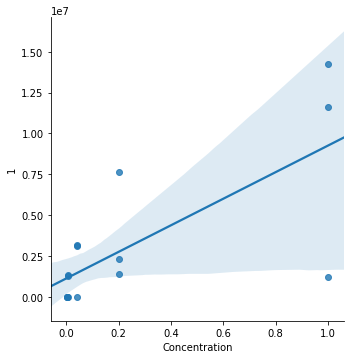

In [89]:
dfa_id2[['Concentration']] = dfa_id2[['Concentration']].apply(pd.to_numeric)
sns.pairplot(dfa_id2, x_vars='Concentration', y_vars=1, size=5, aspect=1, kind='reg')

/anaconda2/envs/python2_rdkit/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


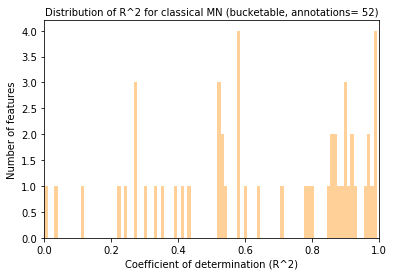

In [90]:
p1=sns.distplot(df_feature_MN['r_square_MN'], bins=100, hist = True, kde = False, color = 'darkorange')
#p1=sns.distplot(df_feature_FMN['r_square_FMN'], bins=70, hist = True, kde = False, color = 'b')
                      
p1.set(xlim=(0, 1))
#p1.set(ylim=(0, 4000))

plt.xlabel('Coefficient of determination (R^2)', size =10)
plt.ylabel('Number of features', size =10)
plt.title('Distribution of R^2 for classical MN (bucketable, annotations= '+str(df_feature_MN.shape[0])+')', size= 10)
plt.savefig('IMG/ClassicalMN_annotations_buckettable.png', dpi=500)
plt.savefig('IMG/ClassicalMN_annotations_buckettable.svg', dpi=500)